# INTRODUCTION
**Author: Antoine Dumont Neira**

**Last Update: July 2025**

This is an example notebook with the basic setup required to run WICKED. WIWCKED can on the three NIRSpec long pass filters; F100LP, F170LP and F290LP, and for data taken with single or multiple NRS detectors. I have tested WICKED to correct for Moire patterns or "Wiggles" on high-z Quasars, Low-luminosity AGNS, Stars and exoplanets, obtaining satisfactory results on all of them.

Here are the main things to understand about WICKED:

1. The model for the wiggles consist of multiple sinudoidal fits of the form f(x) = $A\times \cos(2 \pi f_{\omega} + \phi)$. The spectrum is divided into many smaller slides based on local peaks and vallies of the wiggle spectrum, usually of the order of $\sim 0.1-0.2 \mu m$.

2. The  spectrum in each spaxel is modeleded with a combination of an aperture and annular integrated spectrum, a power-law and a 2nd degree polynomial. This ensures that we can model corretly for changing on the slope of the continuum and equivalent width of stellar/gas features between the model and the data at different radii. This is esential to obtain a "wiggle" spectrum as close to flat as possible, since our sinusoidal model does not includes a continuum, since when the wiggle model and the original spectrum are suubstracted this will alter the shape of the continuum. 

3. How we identify the spaxel affected by wiggles. WICKED flaggs spaxels affected by wiggles based on their Fourier Transform, calculating it's Fourier ratio (see Dumont et al 2025 for details). The frequewncy of wiggles is fairly stable for different type of data, typically between frequncies of 5-60 $[1/\mu m]$. WICKED estimates a frequency prior based on the mean distance of the paks and vallies of the wiggles. The range of frequencies of wiggles is based on the polynomial fit done for the central, brigthest pixel. In other words, it is unique for each datacube. 

4. WICKED is easy to use and fully parallelized. Usual usage time is between 30-60 minutes depending on the datacube and the available number (**N_cores** ) of CPU availables.


## **STEP 0**: SETUP BASIC PARAMETERS

Setup basic information, such as redshift, jwst filter, path to rhe datacube, etc

In this example I run WICKED on a M-type star available on the MAST portal. The data was taken for the proposal "Characterizing the TWA 27 system" PID1270 by the PI: Birkmann, Stephan. The data can be accesed [here](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMFILTERED%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22filters%22%2C%22niceName%22%3A%22filters%22%2C%22values%22%3A%5B%22F170LP%22%5D%2C%22valString%22%3A%22F170LP%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22F170LP%22%7D%5D%2C%22position%22%3A%22181.8894481353499%2C%20-39.54833795144%2C%200.2%22%2C%22paramsService%22%3A%22Mast.Caom.Filtered.Position%22%2C%22title%22%3A%22MAST%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22F170LP%3B%20%20TWA%2027%3B%22%2C%22ra%22%3A181.8894481353499%2C%22dec%22%3A-39.54833795144%2C%22radius%22%3A0.2%2C%22columns%22%3A%22*%22%2C%22columnsConfig%22%3A%22Mast.Caom.Cone%22%7D) . All the credits for this data goes to Birkmann, Stephan

1. WICKED will save the cube in the same folder than the **pathcube_input"** with the extension **"_wicked.fits"**.
2. WICKED will extract all the information it needs from the cube header
3. The **redshift** parameter is only necesary if a line list will be use in the fit. See below

In [27]:
from wicked.WiCKED import WICKED

pathcube_input= "/Users/dumont/Documents/WICKED/DATA/TWA-28/MAST_2024-07-24T2034/JWST/jw01270-o004_t003_nirspec_g235h-f170lp/"
cube_name  = "jw01270-o003_t002_nirspec_g235h-f170lp_s3d.fits"
z = 0.0
fit_wiggles_170lp = WICKED(pathcube=pathcube_input,cube_name=cube_name,redshift=z,)


### Find the center of the datacube
Since WICKED uses an aperture and annular template to fit the spectrum, we need to define a center. WICKED can do this automatically. Otherwise the user can do it by setting: 

<code>
fit_wiggles_170lp.nuc_x = X_CENTER 

fit_wiggles_170lp.nuc_y = Y_CENTER
</code>

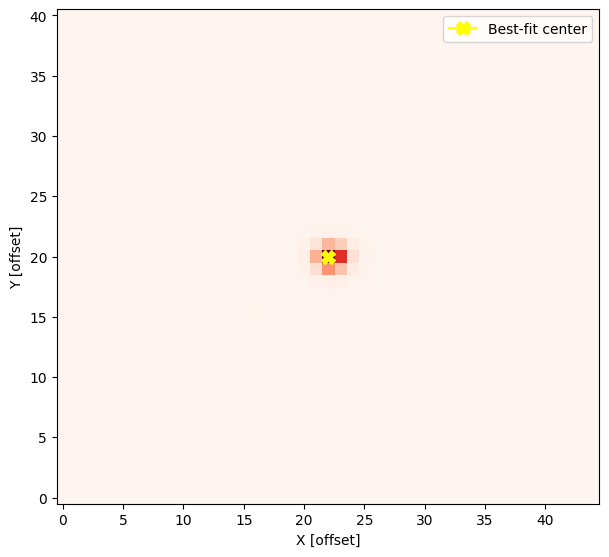


 Center is  x, y =  22 20


In [28]:
fit_wiggles_170lp.find_center(do_plots=True)

#### **MASK BAD REGIONS** 
1. The code performs automated emission line detection to be excluded during the fitting of the wiggle spectrum. The user can define the minimum S/N and width (in pixels) to flag an emission line. Additionally, the user can also provide a file named **"your_lines.dat"** that contains known emission and absorption lines. Please see either CObandheads.dat file in the repository on how to make a list of lines. The lines must be in rest frame and in vacuum. 

2. WICKED will automatically exclude the detector gap between the NRS1 & NRS2 detector for high-resolution datacubes. 

3. The user can manually adjust the width of the masked lines with the keyword: <code> fit_wiggles_170lp.DV = YOU_GUESS in (km/s)/c </code>. Default value is DV=600

Here is a quick example of the parameters you can define to get a better fit:

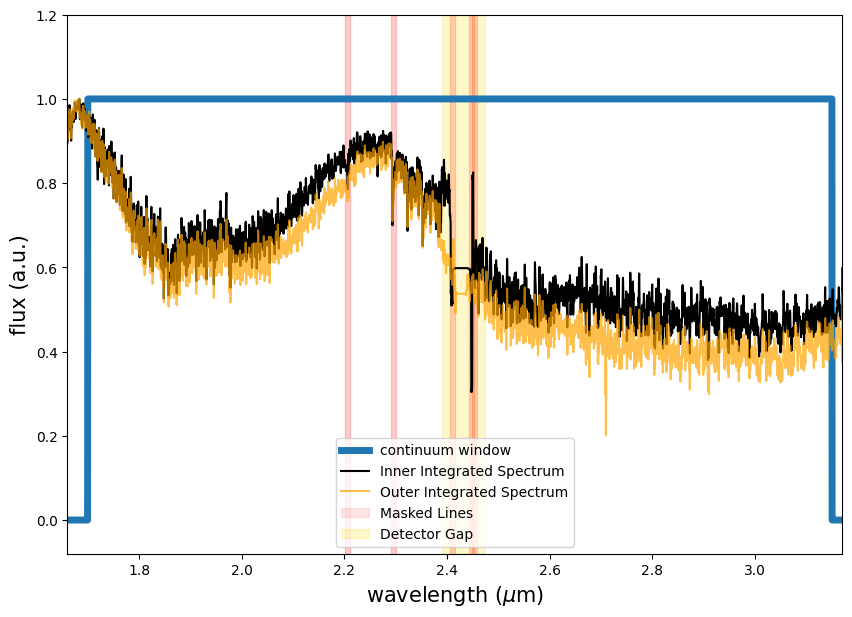

In [34]:
fit_wiggles_170lp.min_peak_snr = 2.5 # Min Signal to noise of line to be masked
fit_wiggles_170lp.peak_width = [10] # Min width in pixels of emission line to be masked
#fit_wiggles_170lp.linefeatures = "CObandheads.dat"   ### M-stars have prominent CO bandheads at ~2.3 microns, so we have passed a list of lines with the most prominent CO bandhead lines
fit_wiggles_170lp.DV =600   ### WIDTH OF THE ABSORPTION/EMISSION LINES
fit_wiggles_170lp.setup_templates(in_radius=5,out_radius=6,do_plots=True)


# **STEP 1:** FIT WIGGLES FOR THE BRIGHTEST SPAXEL

1. Here I perform the fitting only on the brightest spaxel. This constraints the frequencies-wavelength relation of the wiggles. This model will be used later as prior for the Frequewncy fiting for the rest of the pixels in the datacube. 

2. WICKED will divide the spectrum into different wavelenght slides based on the peaks and vallies of the wiggle spectrum to optimally fit the wiggles (green crosses in the middle panel). This procedure is repeated **N_rep** times, to improve the fitting and to obtain a smoother wiggle model. 

3. WICKED will automatically get a frequency prior based on the peaks and vallies of the wiggle spectrum. However, if desired  the user can also quickly modified the initial frequency prior:
<code> fit_wiggles_170lp.frequency_prior = YOUR_GUESS </code>

4. **IMPORTANT!!** For very brigth sources, or sources with extreme changes in the spectral continuum,  we suggest using the keyword:

<code>  fit_wiggles_170lp.smooth_model = True </code>

**Which creates a TEMPLATE of the spectrum continuum based on a signal filtering of the spectrum** which improves drastically the quality of the spectral fit. 

Constraining frequency trend of wiggles. 

Freq. prior of wiggles = 22.6 [1/$\mu$m]
50% OF THE 20 ITERATIONS FINISHED


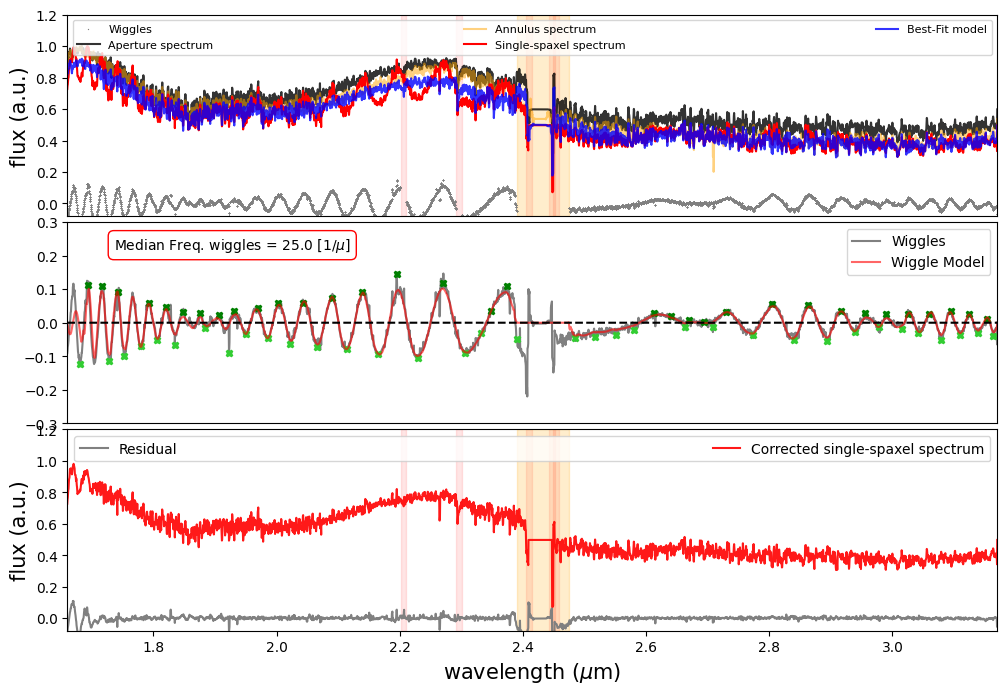

In [35]:
#fit_wiggles_170lp.frequency_prior = 40 ### initial frequency prior for the frequency. Normal between 10-50 [1/mu].
fit_wiggles_170lp.smooth_model = False
fit_wiggles_170lp.clean_central_spaxel(N_rep= 20 ) 

# **STEP 2:** IDENTIFY PIXELS WITH WIGGLES

WICKED evaluates the ratio of the mean amplitude of frequencies associated with wiggles (derived from the central pixel fit) to the standard deviation of amplitudes at longer wavelengths. For pixels affected by wiggles, this ratio exceeds 1-sigma (the threshold ratio "threshold" is defined by the user). In cases where the datacube includes multiple NRS detectors, WICKED performs a Fourier Transform on both and selects the detector where wiggles are most prominent, as determined by the Fourier analysis, to assess whether the spaxel is impacted by wiggles.

By default, the code only searches for wiggles within a circle of radius 10 pixels around the center of the cube. Since wiggles are associated with the central point source, they are not expected to be found at much larger radii.

The second, **smooth_spectrum** is only recommended for lower Signal-to-Noise data where the wiggles can get lost in the noise. when <code>smooth_spectrum="yes" </code> WICKED apply a ~10 pixel mean smooth to the wiggle array, equivalent to ~0.02 microns. 



 GETTING BEST-FIT MODELS FOR EACH PIXEL 

getting best-fit model for task 0 of 193
getting best-fit model for task 1 of 193
getting best-fit model for task 2 of 193
getting best-fit model for task 3 of 193
getting best-fit model for task 4 of 193
getting best-fit model for task 5 of 193
getting best-fit model for task 6 of 193
getting best-fit model for task 7 of 193
getting best-fit model for task 8 of 193
getting best-fit model for task 9 of 193
getting best-fit model for task 10 of 193
getting best-fit model for task 11 of 193
getting best-fit model for task 12 of 193
getting best-fit model for task 13 of 193
getting best-fit model for task 14 of 193
getting best-fit model for task 15 of 193
getting best-fit model for task 16 of 193
getting best-fit model for task 17 of 193
getting best-fit model for task 18 of 193
getting best-fit model for task 19 of 193
getting best-fit model for task 20 of 193
getting best-fit model for task 21 of 193
getting best-fit model for task 22 of 193
g

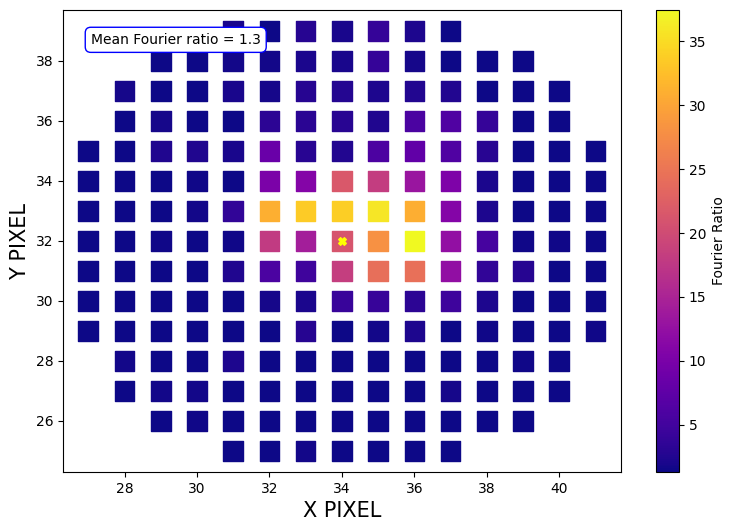

In [5]:
from wicked.FIndWiggles import fourier_wiggle_map

results = fourier_wiggle_map(fit_wiggles_170lp, radius=8,N_Cores=8,smooth_spectrum="no",do_plots=True)


## **Examine the FFT to define threshold**

**This step is not mandatory!**

WICKED has a quick function to display all the necesary plots and information for you to make a more informed decidion on the **threshold** ratio that you want to use to flagg pixels affected by wiggles on the next step, <code> define_affected_pixels </code>

In this example I examine the FFT for a pixel that is I suspect it may or may not have wiggles ( far from the center) using **plot_wiggle_FFT**. 

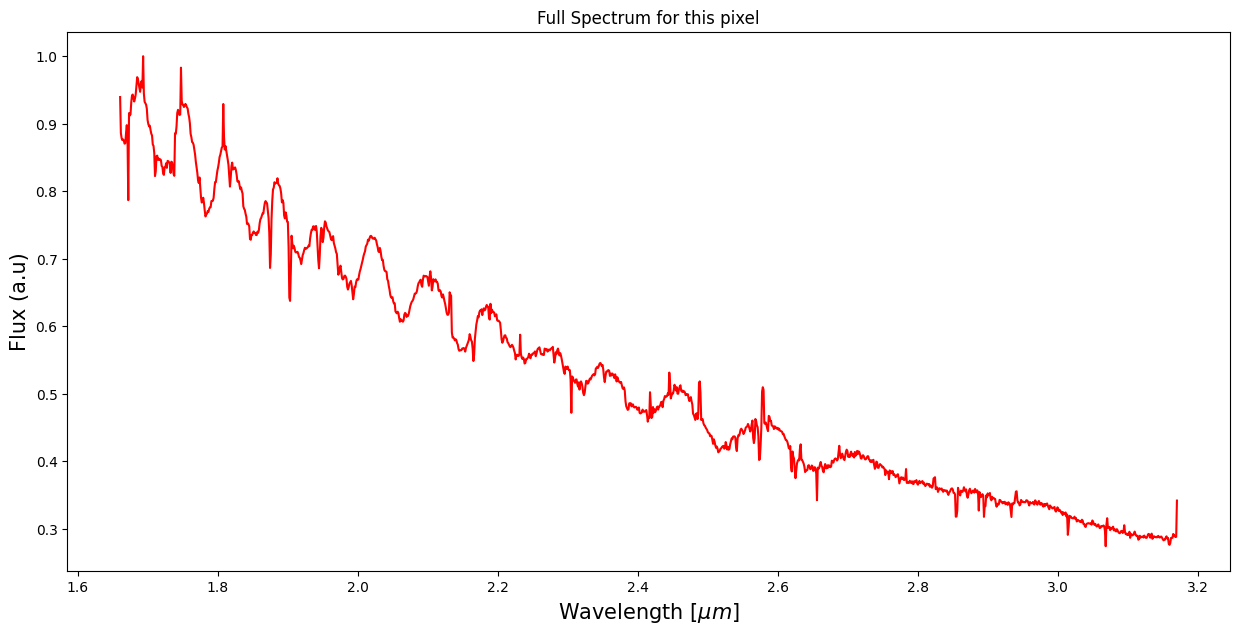


 Fourier Ratio = 21.126


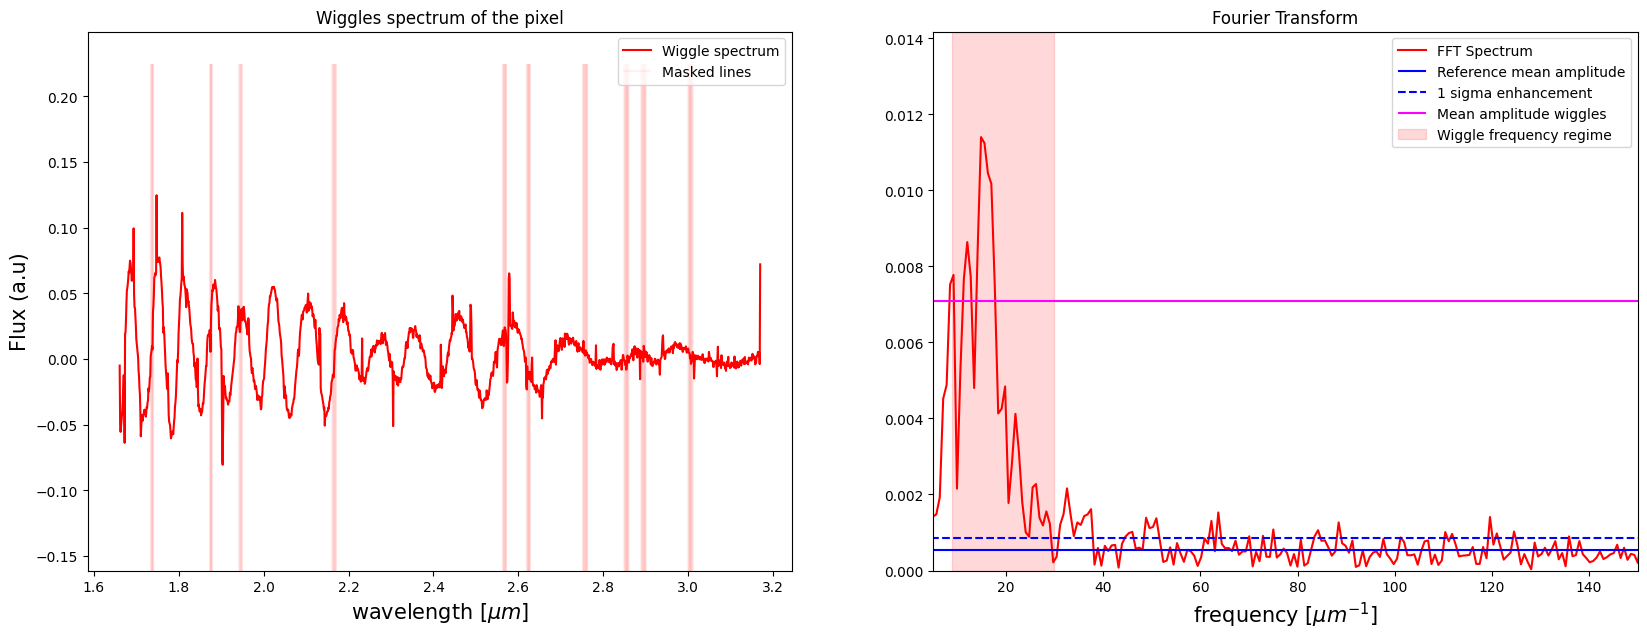

In [7]:
from wicked.FIndWiggles import inspect_spaxel_fft
X, Y = 34,32
inspect_spaxel_fft(fit_wiggles_170lp,X, Y,smooth_spectrum="no")

## Here we select the spaxels to be corrected

Yellow pixels are pixels that will be corrected for wiggles based on your **Fourier_ratio**

**NOTHING IS PERFECT IN LIFE** WICKED is not the exception! If you find that some pixels should be added for correction or excluded you can always do it by hand in the following way, **before** running "define_affected_pixels()":

> <code> fit_wiggles_170lp.add_pixels = [] </code>     # IN THE SAME ORDER AS THE FIGURES [X,Y]

> <code> fit_wiggles_170lp.exclude_pixels = = [] </code>


The user can also store the sigma ratio for using later, and saving time. You can save the list of flagged pixels by setting the arg **save_file=True**
Later you can load the file with the list of affected pixels as follow:

> import pandas as pd

> affected_pixels = pd.read_csv("affected_pixels.csv",header=None)

> affected_pixels = [[i,j] for (i,j) in zip(affected_pixels[0],affected_pixels[1])]


 30 PIXELS AFFECTED BY WIGGLES


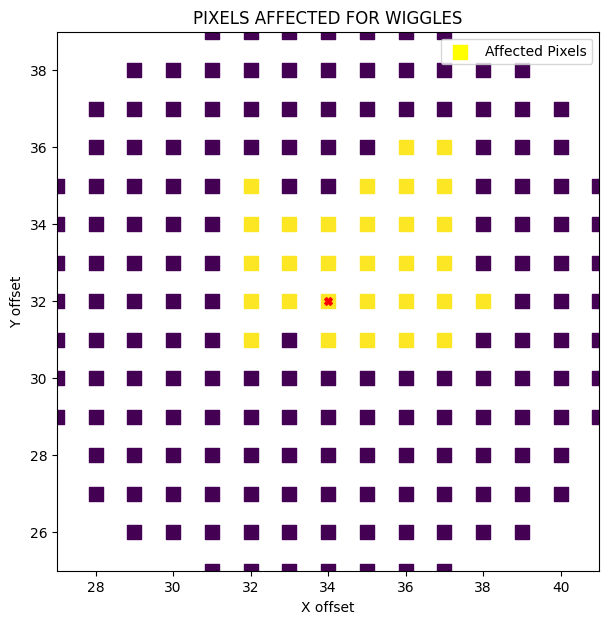

In [8]:
from wicked.FIndWiggles import define_affected_pixels
fit_wiggles_170lp.add_pixels = [[26,20],[25,22]]  ### In this example 2 spaxel had lower Fourier_ratio, and after inspection I add them manually
affected_pixels = define_affected_pixels(fit_wiggles_170lp,results,Fourier_ratio=5.3)


# **STEP 3:** CORRECT WIGGLES
Now that we have identified spaxels affected by wiggles we can correct each pixel flagged. The resulting cube will be saved in the origin folder with the extension "wigglycorrected.fits"

In [ ]:
from wicked.FitWiggles import clean_spaxels
clean_spaxels(fit_wiggles_170lp,affected_pixels,N_rep=15,N_Cores=7,do_plots=True)